In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv("sample-spiral-data.csv")
df.head()

,x1,x2,y
0,0.000000,0.000000,0
1,-0.000650,0.010080,0
2,0.009809,0.017661,0
3,0.007487,0.029364,0
4,-0.000027,0.040404,0


In [62]:
df.shape

(300, 3)

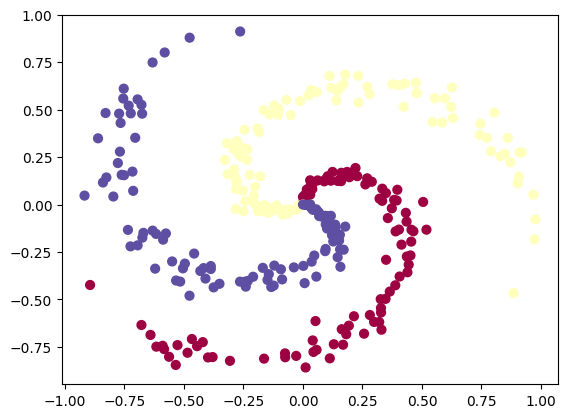

In [63]:
plt.scatter(df["x1"], df["x2"], c=df["y"], s=40, cmap=plt.cm.Spectral)
plt.show()

In [64]:
# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Derivative of the ReLU function
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Softmax activation function
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Derivative of the softmax function (when combined with cross-entropy loss)
def softmax_derivative(y_true, y_pred):
    return y_pred - y_true

# Cross-entropy loss function
def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)  # Avoid log(0)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

In [65]:
# Neural Network class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_hidden = np.random.randn(hidden_size)
        self.bias_output = np.random.randn(output_size)

    def forward(self, X):
        # Forward propagation
        self.hidden_layer_activation = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = relu(self.hidden_layer_activation)
        self.output_layer_activation = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        self.output = softmax(self.output_layer_activation)
        return self.output

    def backward(self, X, y, learning_rate):
        # Backward propagation
        d_output = softmax_derivative(y, self.output)
        error_hidden_layer = d_output.dot(self.weights_hidden_output.T)
        d_hidden = error_hidden_layer * relu_derivative(self.hidden_layer_output)  # ReLU derivative

        # Update weights and biases
        self.weights_hidden_output -= self.hidden_layer_output.T.dot(d_output) * learning_rate
        self.bias_output -= np.sum(d_output, axis=0) * learning_rate

        self.weights_input_hidden -= X.T.dot(d_hidden) * learning_rate
        self.bias_hidden -= np.sum(d_hidden, axis=0) * learning_rate

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs+1):
            # Forward pass
            self.forward(X)
            # Backward pass and update weights
            self.backward(X, y, learning_rate)
            # Print loss every 1000 epochs
            if epoch % 500 == 0:
                loss = cross_entropy_loss(y, self.output)
                print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

In [66]:
# Features (X) and target (y)
X = df[['x1', 'x2']].values  # Use x1 and x2 as features
y_raw = df['y'].values  # Use y as the target labels

# One-hot encode the target labels
y = np.zeros((y_raw.size, y_raw.max() + 1))
y[np.arange(y_raw.size), y_raw] = 1  # One-hot encoding

Epoch 0/2000, Loss: 2.4135
Epoch 500/2000, Loss: 0.1350
Epoch 1000/2000, Loss: 0.0888
Epoch 1500/2000, Loss: 0.4427
Epoch 2000/2000, Loss: 0.0512
Accuracy: 0.9333
Class 0: Precision=0.9474, Recall=0.9000, F1-Score=0.9231
Class 1: Precision=0.8800, Recall=1.0000, F1-Score=0.9362
Class 2: Precision=1.0000, Recall=0.8889, F1-Score=0.9412

Confusion Matrix:
[[18  2  0]
 [ 0 22  0]
 [ 1  1 16]]


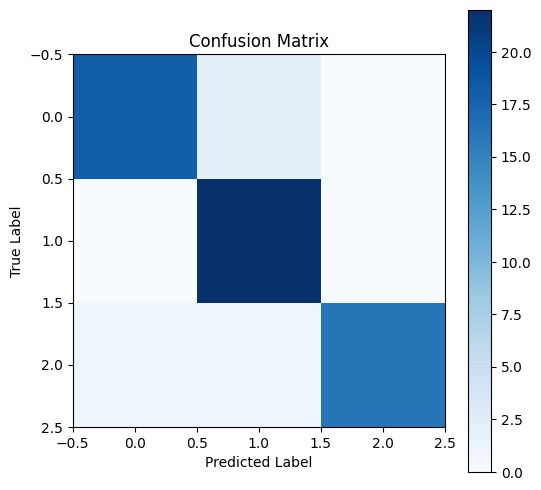

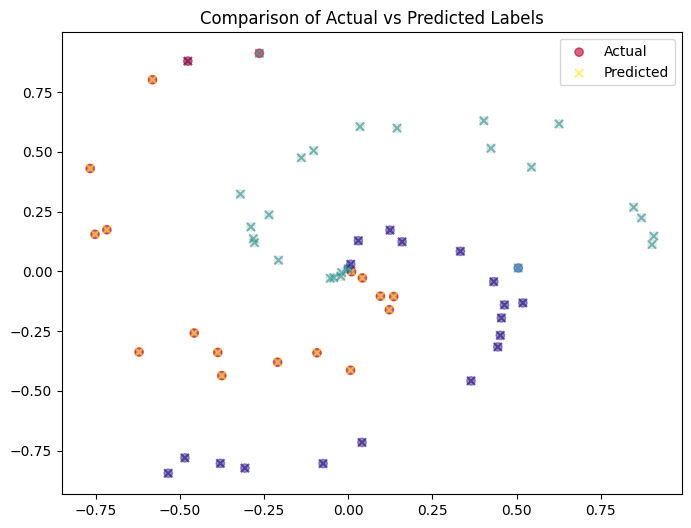

In [67]:
 # Example usage:
if __name__ == "__main__":

    # Manually split data into training and testing sets (without sklearn)
    # Set a fixed random seed for reproducibility
    np.random.seed(42)
    
    # Shuffle indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # Define train-test split ratio
    split_ratio = 0.8  # 80% train, 20% test
    split_index = int(split_ratio * X.shape[0])
    
    # Split data manually
    X_train, X_test = X[indices[:split_index]], X[indices[split_index:]]
    y_train, y_test = y[indices[:split_index]], y[indices[split_index:]]

    # Initialize the neural network
    input_size = X.shape[1]  # Number of features (2: x1, x2)
    hidden_size = 10  # Number of neurons in the hidden layer
    output_size = y.shape[1]  # Number of output classes (from one-hot encoding)
    
    nn = NeuralNetwork(input_size, hidden_size, output_size)


    # Train the model
    epochs = 2000
    learning_rate = 0.01
    nn.train(X_train, y_train, epochs, learning_rate)
    
    # Make predictions on the test set
    y_pred_prob = nn.forward(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
    y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoding back to labels
    
    # === METRICS CALCULATION ===
    
    # 1. Accuracy
    accuracy = np.mean(y_pred == y_test_labels)
    print(f"Accuracy: {accuracy:.4f}")
    
    # 2. Precision, Recall, and F1-Score (for multi-class classification)
    def precision_recall_f1(y_true, y_pred, num_classes):
        precision = np.zeros(num_classes)
        recall = np.zeros(num_classes)
        f1_score = np.zeros(num_classes)
    
        for i in range(num_classes):
            tp = np.sum((y_pred == i) & (y_true == i))  # True Positives
            fp = np.sum((y_pred == i) & (y_true != i))  # False Positives
            fn = np.sum((y_pred != i) & (y_true == i))  # False Negatives
    
            precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
    
        return precision, recall, f1_score
    
    num_classes = output_size
    precision, recall, f1_score = precision_recall_f1(y_test_labels, y_pred, num_classes)
    
    for i in range(num_classes):
        print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-Score={f1_score[i]:.4f}")
    
    # 3. Confusion Matrix
    def confusion_matrix(y_true, y_pred, num_classes):
        matrix = np.zeros((num_classes, num_classes), dtype=int)
        for i in range(len(y_true)):
            matrix[y_true[i], y_pred[i]] += 1
        return matrix
    
    conf_matrix = confusion_matrix(y_test_labels, y_pred, num_classes)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Visualize confusion matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.colorbar()
    plt.show()
    
    # === Visualization of Predictions ===
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_labels, cmap='coolwarm', label='Actual', alpha=0.6)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', marker='x', label='Predicted', alpha=0.6)
    plt.legend()
    plt.title('Comparison of Actual vs Predicted Labels')
    plt.show()

    